# Модель стоимости жилья в Магнитогорске

**id для демонстрации на собеседовании**
id = 3, 37, 82

## Введение

**Задача**

Построить математическую модель стоимости жилья в зависимости от параметров этого жилья.


Модель должна иметь REST API. На вход модели подаются параметры квартиры в формате JSON на выходе получается цена квартиры в формате JSON.

Испытание проводится в режиме демонстрации экрана на собеседовании. Модель тестируется на 3х квартирах на выбор кандидата. (Просьба подготовить исходные данные (запросы) заранее)


**Данные**


В качестве источника исходных данных предлагается использовать данные сайта магнитогорской недвижимости www.citystar.ru.

Размер выборки исходных данных не имеет значения, однако она должна быть представительной (не следует делать ее слишком большой, т.к. задача тестовая).

Данные должны быть загружены в базу данных.

## Импорт библиотек и загрузка данных

In [1017]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
, 
RANDOM_STATE = 12345

In [901]:
# подключаемся к базе данных
cnx = sqlite3.connect('db/magnitogorsk.db')

In [902]:
# загружаем данные
data = pd.read_sql_query("SELECT * FROM offers", cnx)

In [903]:
# закрываем соединение с базой данных
cnx.close()

## Первичное знакомство с данными

In [904]:
def first_look(df, num_of_srtings=5):
    print('Общая информация')
    display(df.info())
    
    print(f'Первые {num_of_srtings} строк(и) данных')
    display(df.head(num_of_srtings))
    
    print('Основные статистические характеристики данных')
    display(df.describe())
    print('Количество пропусков:')
    print(df.isna().sum())
    print()
    
    print('Количество дубликатов:', df.duplicated().sum())

In [905]:
first_look(data)

Общая информация
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 456 entries, 0 to 455
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              456 non-null    int64  
 1   type            445 non-null    object 
 2   district        254 non-null    object 
 3   adress          456 non-null    object 
 4   floor           456 non-null    object 
 5   total_square    456 non-null    float64
 6   living_square   456 non-null    float64
 7   kitchen_square  456 non-null    float64
 8   price           456 non-null    int64  
dtypes: float64(3), int64(2), object(4)
memory usage: 32.2+ KB


None

Первые 5 строк(и) данных


,id,type,district,adress,floor,total_square,living_square,kitchen_square,price
0,1,Трехкомнатная улучшенная,Орджоникидзевский,Ленина пр-т 145/2,1/5,64.0,43.0,8.0,3750
1,2,Трехкомнатная,Ленинский,Октябрьская 12,2/5,87.2,60.0,9.0,8300
2,3,Однокомнатная нестандартная,Орджоникидзевский,Ленина пр-т 135,6/14,36.1,20.0,9.0,3330
3,4,Трехкомнатная нестандартная,Орджоникидзевский,Ленина пр-т 129,5/16,105.0,75.0,14.0,7700
4,5,Двухкомнатная улучшенная,Орджоникидзевский,Сиреневый проезд 12,7/9,50.6,43.0,9.0,3800


Основные статистические характеристики данных


,id,total_square,living_square,kitchen_square,price
count,456.00000,456.000000,456.000000,456.000000,456.000000
mean,228.50000,53.514912,32.120175,8.771250,3744.561404
std,131.78012,21.751910,17.343334,4.007841,1631.107124
min,1.00000,14.100000,0.000000,0.000000,0.000000
25%,114.75000,40.175000,19.000000,6.000000,2700.000000
50%,228.50000,50.000000,30.000000,8.050000,3500.000000
75%,342.25000,65.000000,43.000000,10.000000,4600.000000
max,456.00000,220.000000,150.000000,30.000000,10000.000000


Количество пропусков:
id                  0
type               11
district          202
adress              0
floor               0
total_square        0
living_square       0
kitchen_square      0
price               0
dtype: int64

Количество дубликатов: 0


### Цена

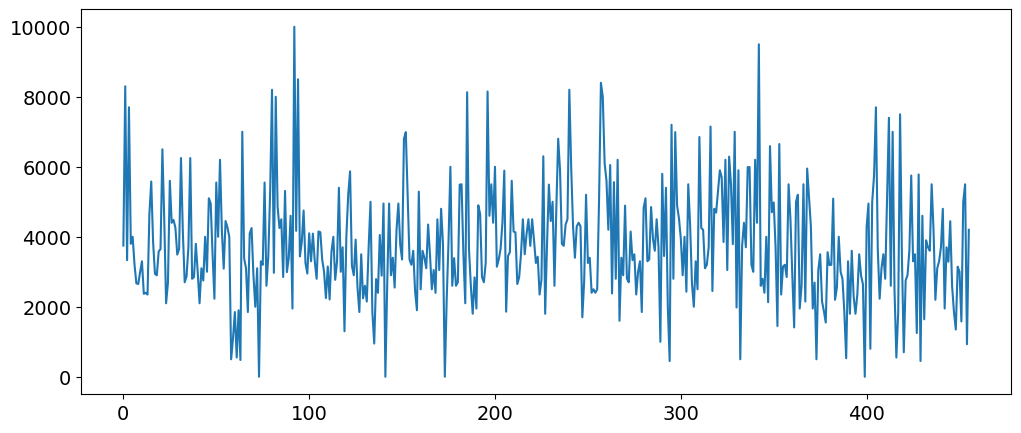

In [906]:
data['price'].plot(figsize=(12, 5));

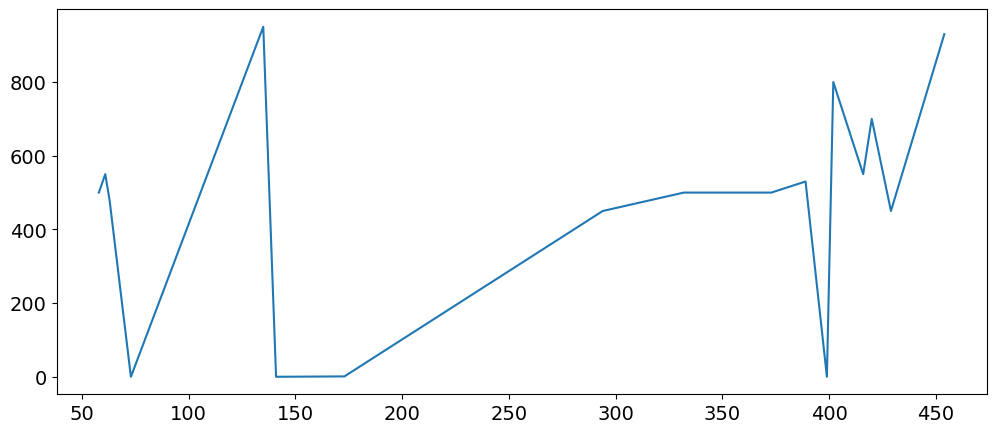

In [907]:
data[data['price'] < 1000]['price'].plot(figsize=(12, 5));

In [908]:
data[data['price'] < 800].shape[0] / data.shape[0] * 100

3.070175438596491

In [909]:
data[data['price'] < 600]

,id,type,district,adress,floor,total_square,living_square,kitchen_square,price
58,59,Трехкомнатная,None,Школьная 10,1/1,59.5,47.0,12.0,500
61,62,Двухкомнатная,None,Новая 1/5,1/2,47.0,29.0,8.0,550
63,64,Двухкомнатная,None,Новая 1/5,1/2,47.0,29.0,8.0,480
73,74,Однокомнатная,None,Первомайская 16,2/4,42.6,20.0,15.0,0
141,142,Однокомнатная,None,Труда 47,4/9,32.0,19.0,6.0,0
173,174,Однокомнатная малосемейка,Правобережный,Советской Армии 37/1,4/9,22.0,12.0,6.0,1
294,295,Однокомнатная,None,Привокзальная 29кв1,1/1,42.5,22.0,12.0,450
332,333,Двухкомнатная,None,Российская 7,2/2,45.0,31.0,6.0,500
373,374,Двухкомнатная,None,ул Черемушки 13,2/2,40.0,22.0,6.0,500
389,390,Трехкомнатная,None,Труда 2,1/2,63.4,0.0,0.0,530


Для трех квартир цена не указана, поэтому удалим эти строки, так как они не подходят ни для обучения модели ни для контроля качества. 

Количество квартир с нетипично низкой ценой составляет около 3 % данных. Удалим их, чтобы модель смогла точнее выявить закономерность.

In [910]:
# контроль размерности
data.shape

(456, 9)

In [911]:
data = data[data['price'] >= 800]

In [912]:
# контроль размерности
data.shape

(442, 9)

### Этаж

In [913]:
data['floor'].isna().sum()

0

In [914]:
def get_floor_num(row):
    return int(row[:row.find('/')])

In [915]:
data['floor_num'] = data['floor'].apply(get_floor_num)

In [916]:
data['floor_num'].isna().sum()

0

In [917]:
def get_total_floors(row):
    return int(row[row.find('/')+1:])

In [918]:
data['total_floors'] = data['floor'].apply(get_total_floors)

In [919]:
data['total_floors'].isna().sum()

0

In [920]:
data.head()

,id,type,district,adress,floor,total_square,living_square,kitchen_square,price,floor_num,total_floors
0,1,Трехкомнатная улучшенная,Орджоникидзевский,Ленина пр-т 145/2,1/5,64.0,43.0,8.0,3750,1,5
1,2,Трехкомнатная,Ленинский,Октябрьская 12,2/5,87.2,60.0,9.0,8300,2,5
2,3,Однокомнатная нестандартная,Орджоникидзевский,Ленина пр-т 135,6/14,36.1,20.0,9.0,3330,6,14
3,4,Трехкомнатная нестандартная,Орджоникидзевский,Ленина пр-т 129,5/16,105.0,75.0,14.0,7700,5,16
4,5,Двухкомнатная улучшенная,Орджоникидзевский,Сиреневый проезд 12,7/9,50.6,43.0,9.0,3800,7,9


Добавим столбец с информацией о том, является ли этаж квартиры первым.

In [921]:
data['is_first_floor'] = data['floor_num'] == 1
data['is_first_floor'] = data['is_first_floor'].astype('int')

Добавим столбец с информацией о том, является ли этаж квартиры последним.

In [922]:
data['is_last_floor'] = data['floor_num'] == data['total_floors']
data['is_last_floor'] = data['is_last_floor'].astype('int')

In [923]:
data.head(10)

,id,type,district,adress,floor,total_square,living_square,kitchen_square,price,floor_num,total_floors,is_first_floor,is_last_floor
0,1,Трехкомнатная улучшенная,Орджоникидзевский,Ленина пр-т 145/2,1/5,64.0,43.0,8.0,3750,1,5,1,0
1,2,Трехкомнатная,Ленинский,Октябрьская 12,2/5,87.2,60.0,9.0,8300,2,5,0,0
2,3,Однокомнатная нестандартная,Орджоникидзевский,Ленина пр-т 135,6/14,36.1,20.0,9.0,3330,6,14,0,0
3,4,Трехкомнатная нестандартная,Орджоникидзевский,Ленина пр-т 129,5/16,105.0,75.0,14.0,7700,5,16,0,0
4,5,Двухкомнатная улучшенная,Орджоникидзевский,Сиреневый проезд 12,7/9,50.6,43.0,9.0,3800,7,9,0,0
5,6,Двухкомнатная улучшенная,Орджоникидзевский,Ленина пр-т 141,4/9,49.7,35.0,9.0,4000,4,9,0,0
6,7,Двухкомнатная,Правобережный,Советской Армии 9,1/5,43.8,28.6,6.0,3200,1,5,1,0
7,8,Однокомнатная брежневка,Правобережный,Карла Маркса 99,4/9,31.0,17.0,6.0,2670,4,9,0,0
8,9,Однокомнатная хрущевка,Ленинский,Ленинградская 37а,2/5,31.0,19.0,6.0,2650,2,5,0,0
9,10,Однокомнатная хабаровский вариант,Орджоникидзевский,Сиреневый проезд 14/2,6/6,37.0,19.0,8.0,2990,6,6,0,1


### Тип квартиры

В столбце с типом квартиры хранятся данные о количестве комнат и типе квартиры. Разделим их и сохраним в двух разных столбцах.

In [924]:
data['type'].isna().sum()

11

In [925]:
data['type'].isna().sum() / data.shape[0] * 100

2.48868778280543

In [926]:
data[data['type'].isna()]

,id,type,district,adress,floor,total_square,living_square,kitchen_square,price,floor_num,total_floors,is_first_floor,is_last_floor
59,60,None,None,Ленина пр-т 212а,1/1,18.4,12.0,5.0,1100,1,1,1,1
83,84,None,None,Карла Маркса 233,8/10,70.0,50.0,7.0,4860,8,10,0,0
97,98,None,Орджоникидзевский,Завенягина 1,5/9,65.1,44.0,8.0,4750,5,9,0,0
140,141,None,None,Торфяная 5/2,1/2,46.8,0.0,0.0,4950,1,2,1,0
161,162,None,None,Карла Маркса 119/1,2/5,41.0,0.0,6.0,3600,2,5,0,0
162,163,None,None,Карла Маркса 117,2/5,41.0,26.0,6.0,3400,2,5,0,0
163,164,None,None,ул Жукова 17/1,4/9,40.1,18.0,9.0,3100,4,9,0,0
176,177,None,None,Западное шоссе 101,2/3,68.0,40.0,0.0,6000,2,3,0,0
355,356,None,None,ул Лесопарковая 93/1,10/10,41.2,28.0,12.5,3150,10,10,0,1
365,366,None,None,Ленина пр-т 114/4,5/14,40.0,18.0,13.0,2620,5,14,0,0


In [927]:
data = data[data['type'].notna()]

In [928]:
data['type'].unique()

array(['Трехкомнатная улучшенная', 'Трехкомнатная ',
       'Однокомнатная нестандартная', 'Трехкомнатная нестандартная',
       'Двухкомнатная улучшенная', 'Двухкомнатная ',
       'Однокомнатная брежневка', 'Однокомнатная хрущевка',
       'Однокомнатная хабаровский вариант', 'Однокомнатная ',
       'Трехкомнатная старой планировки', 'Двухкомнатная нестандартная',
       'Однокомнатная свердловский вариант', 'Двухкомнатная брежневка',
       'Трехкомнатная свердловский вариант',
       'Четырехкомнатная распашонка', 'Двухкомнатная гребенка',
       'Двухкомнатная раздельная', 'Двухкомнатная хрущевка',
       'Двухкомнатная старой планировки',
       'Однокомнатная сталинский вариант', 'Трехкомнатная брежневка',
       'Двухкомнатная сталинский вариант', 'Многокомнатная ',
       'Четырехкомнатная ', 'Однокомнатная улучшенная',
       'Двухкомнатная хабаровский вариант', 'Однокомнатная малосемейка',
       'Четырехкомнатная сталинский вариант', 'Трехкомнатная раздельная',
       'Тре

In [929]:
def get_num_of_rooms(row):
    return row[: row.find(' ')] if row.find(' ') > 0 else None

In [930]:
def get_flat_type(row):
    return 'неизвестно' if (len(row) - row.find(' ') == 1) or (row.find(' ') == -1) else row[row.find(' ')+1:]

In [931]:
get_num_of_rooms('Двухкомнатная свердловский вариант')

'Двухкомнатная'

In [932]:
print(get_flat_type('Двухкомнатная свердловский вариант'))

свердловский вариант


In [933]:
data['num_of_rooms'] = data['type'].apply(get_num_of_rooms)
data['flat_type'] = data['type'].apply(get_flat_type)

In [934]:
data.head()

,id,type,district,adress,floor,total_square,living_square,kitchen_square,price,floor_num,total_floors,is_first_floor,is_last_floor,num_of_rooms,flat_type
0,1,Трехкомнатная улучшенная,Орджоникидзевский,Ленина пр-т 145/2,1/5,64.0,43.0,8.0,3750,1,5,1,0,Трехкомнатная,улучшенная
1,2,Трехкомнатная,Ленинский,Октябрьская 12,2/5,87.2,60.0,9.0,8300,2,5,0,0,Трехкомнатная,неизвестно
2,3,Однокомнатная нестандартная,Орджоникидзевский,Ленина пр-т 135,6/14,36.1,20.0,9.0,3330,6,14,0,0,Однокомнатная,нестандартная
3,4,Трехкомнатная нестандартная,Орджоникидзевский,Ленина пр-т 129,5/16,105.0,75.0,14.0,7700,5,16,0,0,Трехкомнатная,нестандартная
4,5,Двухкомнатная улучшенная,Орджоникидзевский,Сиреневый проезд 12,7/9,50.6,43.0,9.0,3800,7,9,0,0,Двухкомнатная,улучшенная


In [935]:
data['num_of_rooms'].isna().sum()

0

In [936]:
data['flat_type'].isna().sum()

0

In [937]:
data['num_of_rooms'].unique()

array(['Трехкомнатная', 'Однокомнатная', 'Двухкомнатная',
       'Четырехкомнатная', 'Многокомнатная'], dtype=object)

In [938]:
data['flat_type'].unique()

array(['улучшенная', 'неизвестно', 'нестандартная', 'брежневка',
       'хрущевка', 'хабаровский вариант', 'старой планировки',
       'свердловский вариант', 'распашонка', 'гребенка', 'раздельная',
       'сталинский вариант', 'малосемейка', 'смежная', 'евротрешка',
       'полусмежная', 'евродвушка', 'трапеция', 'ленинградский проект'],
      dtype=object)

### Улица

In [939]:
data[data['adress'] == ' '].shape

(4, 15)

In [940]:
data = data[data['adress'] != ' ']

In [941]:
# sorted(data['adress'].unique())
data['adress'].nunique()

366

In [942]:
def get_street(row):
    return row[: row.rfind(' ')]

In [943]:
get_street('ул Сталеваров 18/1',)

'ул Сталеваров'

In [944]:
data['street'] = data['adress'].apply(get_street)

In [945]:
data['street'].isna().sum()

0

In [946]:
data.head()

,id,type,district,adress,floor,total_square,living_square,kitchen_square,price,floor_num,total_floors,is_first_floor,is_last_floor,num_of_rooms,flat_type,street
0,1,Трехкомнатная улучшенная,Орджоникидзевский,Ленина пр-т 145/2,1/5,64.0,43.0,8.0,3750,1,5,1,0,Трехкомнатная,улучшенная,Ленина пр-т
1,2,Трехкомнатная,Ленинский,Октябрьская 12,2/5,87.2,60.0,9.0,8300,2,5,0,0,Трехкомнатная,неизвестно,Октябрьская
2,3,Однокомнатная нестандартная,Орджоникидзевский,Ленина пр-т 135,6/14,36.1,20.0,9.0,3330,6,14,0,0,Однокомнатная,нестандартная,Ленина пр-т
3,4,Трехкомнатная нестандартная,Орджоникидзевский,Ленина пр-т 129,5/16,105.0,75.0,14.0,7700,5,16,0,0,Трехкомнатная,нестандартная,Ленина пр-т
4,5,Двухкомнатная улучшенная,Орджоникидзевский,Сиреневый проезд 12,7/9,50.6,43.0,9.0,3800,7,9,0,0,Двухкомнатная,улучшенная,Сиреневый проезд


In [947]:
data['street'].nunique()

115

In [948]:
def get_street(row):
    dirt = ['ул. ', 'ул.', 'ул ', 'пр.']
    for dot in dirt:
        if dot in row:
            row = row.replace(dot, '')
    if row.find('. ') == 0:
        row = row[2:]
    return row

In [949]:
data['street'] = data['street'].apply(get_street)

In [950]:
streets_to_replace = {
    'зеленый лог' : 'Зеленый Лог',
    'Зеленый лог' : 'Зеленый Лог',
    'Зеленый лог 30 к' : 'Зеленый Лог',
    'Им. газеты \\"Правда\\"' : 'имени газеты Правда',
    'Им. газеты "Правда"' : 'имени газеты Правда',
    'проспект Сиреневый' : 'Сиреневый проезд',
    'карла маркса' : 'Карла Маркса',
    '50 лет Магнитки' : '50-летия Магнитки',
    'Ленина пр-т 210' : 'Ленина пр-т',
    'Советский переулок 12' : 'Советский переулок',
    '26 Горнолыжная' : 'Горнолыжная'
}

In [951]:
data['street'].replace(streets_to_replace, inplace=True)

In [952]:
data.shape

(427, 16)

In [953]:
sorted(data['street'].unique())

['133/1',
 '14',
 '50-летия Магнитки',
 '70 лет Октября',
 'Анджиевского',
 'Болотникова',
 'Бориса Ручьева',
 'Вознесенская',
 'Вокзальная',
 'Ворошилова',
 'Габдрауфа Давлетова',
 'Гагарина',
 'Галиуллина',
 'Герцена',
 'Горнолыжная',
 'Горького',
 'Грязнова',
 'Доменщиков',
 'Жукова',
 'Завенягина',
 'Западное шоссе',
 'Зеленый Лог',
 'Индустриальная',
 'Казакова',
 'Калинина',
 'Калмыкова',
 'Карла Маркса',
 'Коробова',
 'Красноармейская',
 'Кронштадтская',
 'Куйбышева',
 'Курортная',
 'Ленина пр-т',
 'Ленинградская',
 'Лесная',
 'Лесопарковая',
 'Менделеева',
 'Металлургов',
 'Мичурина',
 'Молодежная',
 'Московская',
 'Набережная',
 'Николая Шишка',
 'Октябрьская',
 'Оранжерейная',
 'Панькова',
 'Парковая',
 'Первомайская',
 'Пионерская',
 'Подольская',
 'Помяловского',
 'Пушкина',
 'Раздольная',
 'Ржевского переулок',
 'Садовая',
 'Салтыкова-Щедрина',
 'Сиреневый проезд',
 'Советская',
 'Советский переулок',
 'Советской Армии',
 'Солнечный Берег',
 'Сочинская',
 'Сталеваров',
 'С

In [954]:
data['street'].nunique()

82

### Район

Посмотрим количество пропусков в столбце с данными о районе.

In [955]:
data['district'].isna().sum()

176

Заполним пропуски значением 'неизвестно'.

In [956]:
data['district'].fillna('неизвестно', inplace=True)

In [957]:
data['district'].isna().sum()

0

In [958]:
data['district'].unique()

array(['Орджоникидзевский', 'Ленинский', 'Правобережный', 'неизвестно',
       'Орджоникидзевский (левый берег)', 'ленинский',
       'Орджоникидзевский район', 'Орджо', 'правобережный'], dtype=object)

## Построение модели

### Подготовка обучающей и валидационной выборки.

Выделим характеристики, которые будем использовать для обучения модели.

|столбец|комментарий|
|:--|:--|
|id|не влияет на цену квартиры|
|type|вместо него будем использовать более информативные столбцы, сгенерированные на основе данных из этого столбца|
|**district**|может оказывать влияние|
|adress|вместо него будем использовать более информативные столбцы, сгенерированные на основе данных из этого столбца|
|floor|вместо него будем использовать более информативные столбцы, сгенерированные на основе данных из этого столбца|
|**total_square**|может оказывать влияние|
|**living_square**|может оказывать влияние|
|**kitchen_square**|может оказывать влияние|
|**price**|целевой признак|
|**floor_num**|может оказывать влияние|
|**total_floors**|может оказывать влияние|
|**is_first_floor**|может оказывать влияние|
|**is_last_floor**|может оказывать влияние|
|**num_of_rooms**|может оказывать влияние|
|**flat_type**|может оказывать влияние|
|**street**|может оказывать влияние|

In [959]:
features = data.drop(['id', 'type', 'adress', 'floor', 'price'], axis=1)

In [960]:
features.head()

,district,total_square,living_square,kitchen_square,floor_num,total_floors,is_first_floor,is_last_floor,num_of_rooms,flat_type,street
0,Орджоникидзевский,64.0,43.0,8.0,1,5,1,0,Трехкомнатная,улучшенная,Ленина пр-т
1,Ленинский,87.2,60.0,9.0,2,5,0,0,Трехкомнатная,неизвестно,Октябрьская
2,Орджоникидзевский,36.1,20.0,9.0,6,14,0,0,Однокомнатная,нестандартная,Ленина пр-т
3,Орджоникидзевский,105.0,75.0,14.0,5,16,0,0,Трехкомнатная,нестандартная,Ленина пр-т
4,Орджоникидзевский,50.6,43.0,9.0,7,9,0,0,Двухкомнатная,улучшенная,Сиреневый проезд


In [961]:
target = data['price']

In [962]:
target.head()

0    3750
1    8300
2    3330
3    7700
4    3800
Name: price, dtype: int64

In [963]:
features.isna().sum()

district          0
total_square      0
living_square     0
kitchen_square    0
floor_num         0
total_floors      0
is_first_floor    0
is_last_floor     0
num_of_rooms      0
flat_type         0
street            0
dtype: int64

Разобьем выборки на обучающую и валидационную в отношении 4 : 1.

In [964]:
features_train, features_val, target_train, target_val = train_test_split(
    features,
    target,
    test_size=0.2,
    random_state=RANDOM_STATE
)

In [965]:
features_train.isna().sum()

district          0
total_square      0
living_square     0
kitchen_square    0
floor_num         0
total_floors      0
is_first_floor    0
is_last_floor     0
num_of_rooms      0
flat_type         0
street            0
dtype: int64

### Предварительна обработка данных

Выделим категориальные и числовые признаки.

In [966]:
numeric = ['total_square', 'living_square', 'kitchen_square',
       'floor_num', 'total_floors', 'is_first_floor', 'is_last_floor']
categorical = ['district', 'num_of_rooms', 'flat_type', 'street']

Количество комнат попадает в категориальные признаки, потому что содержит значение «многоквартирная», которое нельзя заменить конкретным числовым значением.

Преобразуем категориальные признаки в числа с помощью порядкового кодирования. 

In [967]:
features_train['district'].isna().sum()

0

In [968]:
oe = OrdinalEncoder(
    handle_unknown='use_encoded_value',
    unknown_value = -1
)

In [969]:
cat_features_train = pd.DataFrame(oe.fit_transform(features_train[categorical]))
cat_features_train.columns = categorical

In [970]:
cat_features_train

,district,num_of_rooms,flat_type,street
0,2.0,2.0,7.0,29.0
1,2.0,3.0,15.0,68.0
2,2.0,2.0,5.0,5.0
3,7.0,0.0,6.0,0.0
4,2.0,3.0,3.0,18.0
...,...,...,...,...
336,5.0,0.0,6.0,23.0
337,2.0,2.0,6.0,23.0
338,5.0,2.0,6.0,29.0
339,0.0,2.0,13.0,39.0


In [971]:
features_train_oe =pd.merge(
    cat_features_train, 
    features_train[numeric].reset_index(drop=True), 
    left_index=True, 
    right_index=True)
features_train_oe

,district,num_of_rooms,flat_type,street,total_square,living_square,kitchen_square,floor_num,total_floors,is_first_floor,is_last_floor
0,2.0,2.0,7.0,29.0,40.3,20.0,9.0,10,10,0,1
1,2.0,3.0,15.0,68.0,65.0,43.0,9.0,6,9,0,0
2,2.0,2.0,5.0,5.0,24.0,14.0,5.0,2,9,0,0
3,7.0,0.0,6.0,0.0,100.0,65.0,25.0,-1,1,0,0
4,2.0,3.0,3.0,18.0,83.0,52.0,20.0,1,10,1,0
...,...,...,...,...,...,...,...,...,...,...,...
336,5.0,0.0,6.0,23.0,46.0,30.0,6.0,4,5,0,0
337,2.0,2.0,6.0,23.0,53.0,30.0,14.0,13,16,0,0
338,5.0,2.0,6.0,29.0,26.0,14.0,7.0,5,16,0,0
339,0.0,2.0,13.0,39.0,33.0,20.0,7.0,3,5,0,0


In [972]:
target_train = target_train.reset_index(drop=True)

In [973]:
cat_features_val = pd.DataFrame(oe.transform(features_val[categorical]))
cat_features_val.columns = categorical

In [974]:
features_val_oe =pd.merge(
    cat_features_val, 
    features_val[numeric].reset_index(drop=True), 
    left_index=True, 
    right_index=True)
features_val_oe

,district,num_of_rooms,flat_type,street,total_square,living_square,kitchen_square,floor_num,total_floors,is_first_floor,is_last_floor
0,2.0,0.0,7.0,52.0,56.1,35.0,9.0,7,9,0,0
1,2.0,3.0,6.0,47.0,67.0,45.0,8.0,2,5,0,0
2,7.0,0.0,6.0,52.0,53.0,40.0,9.0,9,9,0,1
3,7.0,4.0,6.0,53.0,61.0,45.0,7.0,4,5,0,0
4,0.0,2.0,6.0,41.0,26.0,13.0,7.0,1,3,1,0
...,...,...,...,...,...,...,...,...,...,...,...
81,7.0,2.0,6.0,55.0,31.0,18.0,6.0,5,9,0,0
82,5.0,0.0,9.0,53.0,44.0,30.0,6.0,1,5,1,0
83,7.0,2.0,6.0,68.0,32.7,19.0,6.0,6,9,0,0
84,5.0,3.0,0.0,58.0,65.0,47.0,6.0,2,5,0,0


In [975]:
target_val = target_val.reset_index(drop=True)

In [976]:
target_val

0     4260
1     3000
2     3600
3     4050
4     1000
      ... 
81    2100
82    3450
83    2650
84    4200
85    5990
Name: price, Length: 86, dtype: int64

Теперь масштабируем наши данные.

In [977]:
sscaler = StandardScaler()

In [978]:
features_train_sc = pd.DataFrame(sscaler.fit_transform(features_train_oe))
features_train_sc.columns = features_train_oe.columns

In [979]:
features_train_sc.head()

,district,num_of_rooms,flat_type,street,total_square,living_square,kitchen_square,floor_num,total_floors,is_first_floor,is_last_floor
0,-0.768132,0.252053,-0.047680,-0.360772,-0.639131,-0.707860,0.032162,2.360121,1.100421,-0.517357,1.645151
1,-0.768132,1.006002,2.361058,1.592775,0.497479,0.584627,0.032162,0.838038,0.803316,-0.517357,-0.607847
2,-0.768132,0.252053,-0.649865,-1.562956,-1.389202,-1.045031,-1.002495,-0.684044,0.803316,-0.517357,-0.607847
3,1.043299,-1.255844,-0.348773,-1.813411,2.108060,1.820918,4.170792,-1.825606,-1.573524,-0.517357,-0.607847
4,-0.768132,1.006002,-1.252049,-0.911773,1.325777,1.090382,2.877470,-1.064565,1.100421,1.932902,-0.607847


In [980]:
features_val_sc = pd.DataFrame(sscaler.transform(features_val_oe))
features_val_sc.columns = features_val_oe.columns

In [981]:
features_val_sc.head()

,district,num_of_rooms,flat_type,street,total_square,living_square,kitchen_square,floor_num,total_floors,is_first_floor,is_last_floor
0,-0.768132,-1.255844,-0.047680,0.791320,0.087931,0.135066,0.032162,1.218559,0.803316,-0.517357,-0.607847
1,-0.768132,1.006002,-0.348773,0.540865,0.589512,0.697017,-0.226502,-0.684044,-0.385104,-0.517357,-0.607847
2,1.043299,-1.255844,-0.348773,0.791320,-0.054721,0.416041,0.032162,1.979600,0.803316,-0.517357,1.645151
3,1.043299,1.759951,-0.348773,0.841411,0.313412,0.697017,-0.485166,0.076997,-0.385104,-0.517357,-0.607847
4,-1.492704,0.252053,-0.348773,0.240319,-1.297169,-1.101226,-0.485166,-1.064565,-0.979314,1.932902,-0.607847


Модель линейной регрессии

In [982]:
class MyLinearRegression:
    
    def fit(self, train_features, train_target):
        X = np.concatenate((np.ones((train_features.shape[0], 1)), train_features), axis=1)
        y = train_target
        w = np.linalg.inv(X.T @ X) @ X.T @ y
        self.w = w[1:]
        self.w0 = w[0]

    def predict(self, test_features):
        return test_features.dot(self.w) + self.w0

In [983]:
# наша модель
model_1 = MyLinearRegression()
model_1.fit(features_train_sc, target_train)
predictions = model_1.predict(features_val_sc)

# метрика MAE
mae = mean_absolute_error(target_val, predictions)
print(mae)

672.0942860631774


In [984]:
target_val

0     4260
1     3000
2     3600
3     4050
4     1000
      ... 
81    2100
82    3450
83    2650
84    4200
85    5990
Name: price, Length: 86, dtype: int64

In [985]:
for i in range(10):
    print(target_val.iloc[i], predictions.iloc[i])

4260 4052.99688637837
3000 4712.333898575558
3600 3806.7982454762073
4050 4351.10037000778
1000 2236.5064927159356
3500 3497.239442095292
3700 3977.1318628837444
4250 4555.614779034155
5100 5280.829261751394
6990 5531.14307727672


In [986]:
from sklearn.tree import DecisionTreeRegressor

In [987]:
DTR = DecisionTreeRegressor(
    max_depth=10,
    random_state=RANDOM_STATE
)

In [988]:
DTR.fit(features_train_sc, target_train)

DecisionTreeRegressor(max_depth=10, random_state=12345)

In [989]:
predictionsDTR = DTR.predict(features_val_sc)

# метрика MAE
maeDTR = mean_absolute_error(target_val, predictionsDTR)
print(maeDTR)

663.9269149618232


In [990]:
from sklearn.ensemble import RandomForestRegressor

In [1014]:
# список гиперпараметров и их значений
search_space = {
    'criterion' : ['squared_error', 'absolute_error', 'friedman_mse', 'poisson'],
    'max_depth' : [5, 10, 15],
    'n_estimators' : [50, 100, 200],
    'max_features' : ['sqrt', 'log2', 1]
}

In [1015]:
model_rfr = RandomForestRegressor(
    random_state=RANDOM_STATE
)

In [1019]:
GS = GridSearchCV(
    estimator=model_rfr,
    param_grid=search_space,
    scoring='neg_mean_absolute_error',
    cv=3,
    verbose=4
)

In [1020]:
GS.fit(features_train_sc, target_train)

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV 1/3] END criterion=squared_error, max_depth=5, max_features=sqrt, n_estimators=50;, score=-550.101 total time=   0.0s
[CV 2/3] END criterion=squared_error, max_depth=5, max_features=sqrt, n_estimators=50;, score=-685.601 total time=   0.0s
[CV 3/3] END criterion=squared_error, max_depth=5, max_features=sqrt, n_estimators=50;, score=-539.805 total time=   0.0s
[CV 1/3] END criterion=squared_error, max_depth=5, max_features=sqrt, n_estimators=100;, score=-564.603 total time=   0.0s
[CV 2/3] END criterion=squared_error, max_depth=5, max_features=sqrt, n_estimators=100;, score=-669.839 total time=   0.0s
[CV 3/3] END criterion=squared_error, max_depth=5, max_features=sqrt, n_estimators=100;, score=-529.349 total time=   0.0s
[CV 1/3] END criterion=squared_error, max_depth=5, max_features=sqrt, n_estimators=200;, score=-568.342 total time=   0.0s
[CV 2/3] END criterion=squared_error, max_depth=5, max_features=sqrt, n_estimat

GridSearchCV(cv=3, estimator=RandomForestRegressor(random_state=12345),
             param_grid={'criterion': ['squared_error', 'absolute_error',
                                       'friedman_mse', 'poisson'],
                         'max_depth': [5, 10, 15],
                         'max_features': ['sqrt', 'log2', 1],
                         'n_estimators': [50, 100, 200]},
             scoring='neg_mean_absolute_error', verbose=4)

In [1022]:
GS.best_score_

-567.0945135855253

In [1024]:
GS.best_estimator_

RandomForestRegressor(criterion='poisson', max_depth=15, max_features='sqrt',
                      n_estimators=200, random_state=12345)

In [1047]:
RFR = RandomForestRegressor(
    # criterion='poisson',
    max_depth=10, 
    # max_features='sqrt',
    n_estimators=100,
    random_state=RANDOM_STATE
)

In [1048]:
# RFR = RandomForestRegressor(
#     max_depth=10,
#     random_state=RANDOM_STATE,
#     n_estimators=100
# )

In [1050]:
features_val_oe = features_val_oe.reset_index(drop=True)
features_val_oe = features_val_oe.reset_index(drop=True)


In [1053]:
features_train_oe

,district,num_of_rooms,flat_type,street,total_square,living_square,kitchen_square,floor_num,total_floors,is_first_floor,is_last_floor
0,2.0,2.0,7.0,29.0,40.3,20.0,9.0,10,10,0,1
1,2.0,3.0,15.0,68.0,65.0,43.0,9.0,6,9,0,0
2,2.0,2.0,5.0,5.0,24.0,14.0,5.0,2,9,0,0
3,7.0,0.0,6.0,0.0,100.0,65.0,25.0,-1,1,0,0
4,2.0,3.0,3.0,18.0,83.0,52.0,20.0,1,10,1,0
...,...,...,...,...,...,...,...,...,...,...,...
336,5.0,0.0,6.0,23.0,46.0,30.0,6.0,4,5,0,0
337,2.0,2.0,6.0,23.0,53.0,30.0,14.0,13,16,0,0
338,5.0,2.0,6.0,29.0,26.0,14.0,7.0,5,16,0,0
339,0.0,2.0,13.0,39.0,33.0,20.0,7.0,3,5,0,0


In [1052]:
RFR.fit(features_train_oe, target_train)

RandomForestRegressor(max_depth=10, random_state=12345)

In [1055]:
predictionsRFR = RFR.predict(features_val_oe)

# метрика MAE
maeRFR = mean_absolute_error(target_val, predictionsRFR)
print(maeRFR)

503.25228523155494


In [1056]:
mean_absolute_percentage_error(target_val, predictionsRFR)*100

22.796016460640452

In [1057]:
mean_squared_error(target_val, predictionsRFR) ** 0.5

720.2353498439822

In [1058]:
for i in range(10):
    print(target_val.iloc[i], predictionsRFR[i])

4260 4080.392189639629
3000 4363.220167630616
3600 4069.992041430793
4050 4002.3244936477545
1000 2133.0936324786326
3500 3573.091282907472
3700 3859.2183928062914
4250 4001.4275375939847
5100 4669.185009379509
6990 6645.989399867376


In [1059]:
len(target_val)

86

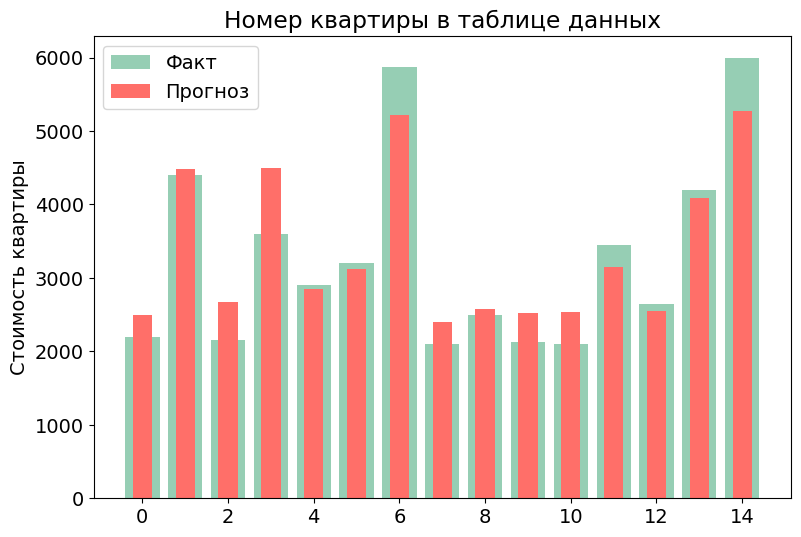

In [1060]:
# построим диаграмму значений
fig, ax = plt.subplots(figsize=(9, 6))
plt.rc('font', size=14)
x = [i for i in range(15)]

ax.bar(x, target_val[71:], color='#96ceb4', label='Факт')
ax.bar(x, predictionsRFR[71:], width = .45, color='#ff6f69', label='Прогноз')
# ax.plot(x, [y_test[:13].median() for i in range(13)], color='#36454f', label='Медиана')



ax.set_ylabel('Стоимость квартиры')
ax.set_title('Номер квартиры в таблице данных')
ax.legend()
plt.show()

In [1061]:
sorted(zip(RFR.feature_importances_, features_val_oe.columns), reverse=True)

[(0.7770291694257448, 'total_square'),
 (0.040231378668611185, 'total_floors'),
 (0.039160227109966854, 'kitchen_square'),
 (0.03543478054277892, 'living_square'),
 (0.03045132933756871, 'street'),
 (0.028316163793768383, 'num_of_rooms'),
 (0.019135427084902422, 'floor_num'),
 (0.012814478101897139, 'district'),
 (0.010394255711051355, 'flat_type'),
 (0.004588425797274254, 'is_last_floor'),
 (0.0024443644264360276, 'is_first_floor')]

In [1075]:
most_important = [
    'total_square', 
    'total_floors', 
    'kitchen_square', 
    'living_square', 
    'street', 
    'num_of_rooms', 
    'floor_num',
    'district',
    'flat_type'
]

In [1076]:
RFR_mi = RandomForestRegressor(
    # criterion='poisson',
    max_depth=10, 
    # max_features='sqrt',
    n_estimators=100,
    random_state=RANDOM_STATE
)

In [1077]:
RFR.fit(features_train_sc[most_important], target_train)

RandomForestRegressor(max_depth=10, random_state=12345)

In [1078]:
predictionsRFR_mi = RFR.predict(features_val_sc[most_important])

# метрика MAE
maeRFR_mi = mean_absolute_error(target_val, predictionsRFR_mi)
print(maeRFR_mi)

509.2807473518596


In [ ]:
 3, 37, 82

In [89]:
example_1 = data[data['id'] == 3]

In [91]:
example_1['price']

2    3330
Name: price, dtype: int64

In [ ]:
model_1.predict(sscaler.transform())